# NYC Census Tract Adjacency Matrix Generation

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tract_weights import TractWeightsGenerator
from IPython.display import display, HTML

%matplotlib inline


## Generate Weights

First, let's compute all types of weights matrices and analyze their properties.

In [11]:
# Initialize weights generator
generator = TractWeightsGenerator("/share/ju/matt/street-flooding/aggregation/geo/data/ct-nyc-2020.geojson")

blacklist = {
    844: [1196, 1190, 1172],
    1172: [989],
    1169: [989, 988],
    1168: [988, 839, 2032],
    1984: [1983, 2032],
    2045: [2156], 
    841: [1619], 
    2002: [2252], 
    973: [1907], 
    952: [2064], 
    2026: [2172],
    2065: [2282], 
    2161: [156],
    2279: [1041], 
    2225: [975], 
}

#generator.set_blacklist(blacklist)

# Compute all weights
custom_geometric_weights = generator.compute_custom_geometric_weights(buffer_dist=500, debug=True)


In [12]:
custom_geometric_weights

{'custom_geometric': WeightsAnalysis(weights_matrix=array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.]]), n_connections=8281, isolated_tracts=[0, 2277], avg_connections=7.123440860215053, description='Custom Geometric with 500ft buffer')}

In [15]:
# export weights 
os.makedirs("../../../data/adjacency/cg_500/", exist_ok=True)
generator.export_adjacency_lists("custom_geometric", output_dir="../../../data/adjacency/cg_500/")

('../../../data/adjacency/cg_500/ct_nyc_adj_list_custom_geometric_node1.txt',
 '../../../data/adjacency/cg_500/ct_nyc_adj_list_custom_geometric_node2.txt')

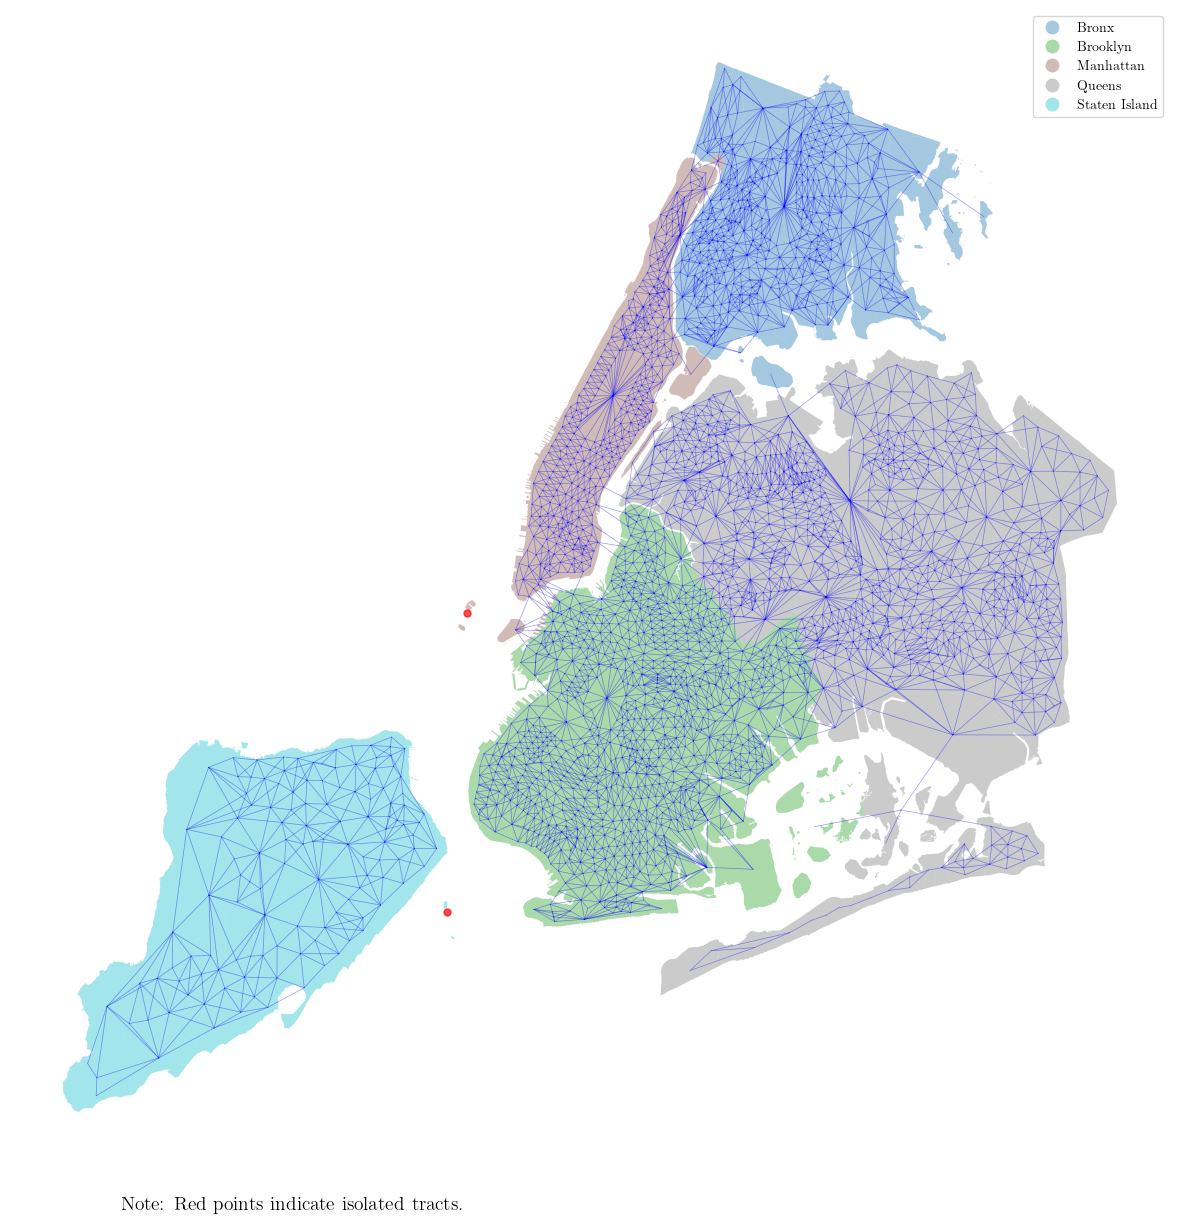

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar

# enable latex plotting 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def create_academic_map(gdf, adj_matrix, method_name, isolated_nodes=None):
    # Project to NY State Plane (feet)
    gdf_proj = gdf.to_crs('EPSG:3857')
    
    fig, ax = plt.subplots(figsize=(15, 15))
    


    # Add note about scale
    plt.figtext(0.2, 0.08, 
                f'Note: Red points indicate isolated tracts.',
                fontsize=14)
    
    # Plot the data
    gdf_proj.plot(ax=ax, column='BoroName', categorical=True, 
                 alpha=0.4, legend=True)
    
    # Add adjacency lines
    for i in range(adj_matrix.shape[0]):
        for j in range(i+1, adj_matrix.shape[1]):
            if adj_matrix[i,j] == 1:
                cent1 = gdf_proj.iloc[i].geometry.centroid
                cent2 = gdf_proj.iloc[j].geometry.centroid
                ax.plot([cent1.x, cent2.x], [cent1.y, cent2.y], 
                       color='blue', alpha=0.4, linewidth=0.5)
    
    # Handle isolated nodes if provided
    if isolated_nodes:
        for idx in isolated_nodes:
            centroid = gdf_proj.iloc[idx].geometry.centroid
            ax.plot(centroid.x, centroid.y, 'ro', markersize=5, alpha=0.7)

    
    # Remove axes for cleaner map presentation
    ax.set_axis_off()
    
    return fig, ax

# Create map for custom geometric method
gdf = gpd.read_file("/share/ju/matt/street-flooding/aggregation/geo/data/ct-nyc-2020.geojson")
gdf = gdf.to_crs(epsg=2263)
adj_matrix = custom_geometric_weights['custom_geometric'].weights_matrix
isolated_nodes = custom_geometric_weights['custom_geometric'].isolated_tracts
fig, ax = create_academic_map(gdf, adj_matrix, 'Custom Geometric Method', isolated_nodes)

plt.savefig('feb5_testing_500ft_buffer_adjacency.png', dpi=300, bbox_inches='tight')

In [ ]:
# export